### Outline

This Ipython notebook is focused on data preparation : fill missing values and multicollinearity in dataset

   * Missing Value 
   * Outlier 
   * Multicollinearity 
   * Simple Submission 

### Setup Imports and Variables

In [1]:
import pandas as pd
import numpy as np
import pylab as plt
import matplotlib.pyplot as plt
##import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import numpy as np
import seaborn as sns
from scipy import stats
color = sns.color_palette()
%matplotlib inline
# Set the global default size of matplotlib figures
plt.rc('figure', figsize=(12, 5))

# Size of matplotlib figures that contain subplots
fizsize_with_subplots = (12,12)

# Size of matplotlib histogram bins
bin_size = 10

### Load the Data

In [2]:
df_train = pd.read_csv('./data/input/train.csv')
df_train.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


In [3]:
df_train.shape

(30471, 292)

In [3]:
df_test = pd.read_csv('./data/input/test.csv')
df_test.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000
0,30474,2015-07-01,39.0,20.7,2,9,1,1998.0,1,8.9,...,8,0,0,0,1,10,1,0,14,1
1,30475,2015-07-01,79.2,NaN,8,17,1,0.0,3,1.0,...,4,1,1,0,2,11,0,1,12,1
2,30476,2015-07-01,40.5,25.1,3,5,2,1960.0,2,4.8,...,42,11,4,0,10,21,0,10,71,11
3,30477,2015-07-01,62.8,36.0,17,17,1,2016.0,2,62.8,...,1,1,2,0,0,10,0,0,2,0
4,30478,2015-07-01,40.0,40.0,17,17,1,0.0,1,1.0,...,5,1,1,0,2,12,0,1,11,1


In [5]:
#basic variables
basic_feature = ['timestamp', 'full_sq', 'life_sq', 'floor', 'max_floor', 'material', 'build_year',
                 'num_room', 'kich_sq', 'state','product_type', 'sub_area']

In [6]:
df_train['build_year'].describe(include='all')

count    1.686600e+04
mean     3.068057e+03
std      1.543878e+05
min      0.000000e+00
25%      1.967000e+03
50%      1.979000e+03
75%      2.005000e+03
max      2.005201e+07
Name: build_year, dtype: float64

### Missing Value

In [7]:
#missing value
missing_build_count = df_train[df_train['build_count_1921-1945'].isnull()]
missing_build_count.shape

(4991, 292)

In [8]:
missing_df = missing_build_count.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.ix[missing_df['missing_count']>0]

In [9]:
missing_df.head()

,column_name,missing_count
3,life_sq,2698
4,floor,37
5,max_floor,1721
6,material,1721
7,build_year,3424


In [10]:
df_train['cafe_sum_500_max_price_avg'].describe()

count    17190.000000
mean      1247.023497
std        526.539159
min        500.000000
25%       1000.000000
50%       1166.670000
75%       1500.000000
max       6000.000000
Name: cafe_sum_500_max_price_avg, dtype: float64

In [11]:
df_train['state'].describe()

count    16912.000000
mean         2.107025
std          0.880148
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         33.000000
Name: state, dtype: float64

In [92]:
#Summary clean missing value methods
##method 1
### drop missing value >0.35 of total observations, keep state and build_year for training data
def drop_high_volumn_missing(df):
    not_move = ["build_year","state"]
    high_missing_train_feature= df.columns[df.isnull().sum()>0.35*len(df)].tolist()
    
    for g in not_move:
        if g in high_missing_train_feature:
            high_missing_train_feature.remove(g)
    df.drop(high_missing_train_feature,axis = 1)    
    return df

In [94]:
drop_high_volumn_missing(df_train).head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


In [14]:
## method 2 fill cafe_sum missing with 0; fill state with 0
def fill_missing_zero(df):
    df.filter(regex=r'^cafe_', axis=1).fillna(0, inplace=True)
    df['state'].fillna(0,inplace=True)
    return df

In [15]:
df_train.filter(regex=r'^cafe_', axis=1).head()

,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,...,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high
0,0,NaN,NaN,NaN,0,0,0,0,0,0,...,708.57,1185.71,947.14,12,39,48,40,9,4,0
1,5,860.00,1500.00,1180.00,0,1,3,0,0,1,...,673.81,1148.81,911.31,9,49,65,36,15,3,0
2,3,666.67,1166.67,916.67,0,0,2,1,0,0,...,702.68,1196.43,949.55,10,29,45,25,10,3,0
3,2,1000.00,1500.00,1250.00,0,0,0,2,0,0,...,931.58,1552.63,1242.11,4,7,21,15,11,2,1
4,48,702.22,1166.67,934.44,3,17,10,11,7,0,...,853.88,1411.45,1132.66,143,566,578,552,319,108,17


Cafe_count = 0 then cafe_*_price is missing

In [16]:
## drop build_ columns: drop na obs or drop columns
def drop_build_function(df):
    not_move = ["build_year"]
    build_feature = df.filter(regex=r'^build_count_', axis=1).columns.tolist()
    build_feature2 = df.filter(regex=r'^raion_build_count_', axis=1).columns.tolist()
    for e in build_feature:
        for g in not_move:
            if e==g:
                high_missing_train_feature.remove(e)
    build_feature.extend(build_feature2)
    return build_feature

In [17]:
drop_build_function(df_train)

['build_count_block',
 'build_count_wood',
 'build_count_frame',
 'build_count_brick',
 'build_count_monolith',
 'build_count_panel',
 'build_count_foam',
 'build_count_slag',
 'build_count_mix',
 'build_count_before_1920',
 'build_count_1921-1945',
 'build_count_1946-1970',
 'build_count_1971-1995',
 'build_count_after_1995',
 'raion_build_count_with_material_info',
 'raion_build_count_with_builddate_info']

### Summary of clean

In [4]:
# drop missing value >0.35 of total observations
# keep state and build_year for training data
def drop_high_volumn_missing(df):
    not_move = ["build_year","state"]
    high_missing_train_feature= df.columns[df.isnull().sum()>0.35*len(df)].tolist()
    
    for g in not_move:
        if g in high_missing_train_feature:
            high_missing_train_feature.remove(g)
    df.drop(high_missing_train_feature,axis = 1)    
    return df

## drop build_ columns: drop na obs or drop columns
def drop_build_function(df):
    not_move = ["build_year"]
    build_feature = df.filter(regex=r'^build_count_', axis=1).columns.tolist()
    build_feature2 = df.filter(regex=r'^raion_build_count_', axis=1).columns.tolist()
    for e in build_feature:
        for g in not_move:
            if e==g:
                high_missing_train_feature.remove(e)
    build_feature.extend(build_feature2)
    df.drop(build_feature,axis = 1)
    return df

# remove outliers
'''def reject_outliers(df, m = 1):
    d = np.abs(df - np.median(df))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return df[s<m]
'''
def reject_outliers(df, iq_range=0.5):
    #df[np.abs(df.Data-df.Data.mean())<=(3*df.Data.std())]
    pcnt = (1 - iq_range) / 2
    qlow, median, qhigh = df.dropna().quantile([pcnt, 0.50, 1-pcnt])
    iqr = qhigh - qlow
    return df[ (df - median).abs() <= iqr]

def clean_data(df):
    # convert object column to numeric
    char_columns = (df.dtypes[df.dtypes.map(lambda x : x =='object')]).index
    float_columns = (df.dtypes[df.dtypes.map(lambda x : x =='float64')]).index
    le=LabelEncoder()
    for feature in char_columns:
        df[feature]=le.fit_transform(df[feature])
    # cvert float64 to float32
    df[float_columns]=df[float_columns].astype(np.float32)
    
    # fill build_ and cafe_, state, NA to 0

    df.filter(regex=r'^cafe_', axis=1).fillna(0, inplace=True)
    #build_feature
    not_move = ["build_year"]
    build_feature = df.filter(regex=r'^build_count_', axis=1).columns.tolist()
    build_feature2 = df.filter(regex=r'^raion_build_count_', axis=1).columns.tolist()
    for e in build_feature:
        for g in not_move:
            if e==g:
                high_missing_train_feature.remove(e)
    build_feature.extend(build_feature2)
    df[build_feature].fillna(0,inplace=True)
    #fill state
    df['state'].fillna(0,inplace=True)    
    return df

### Multicollinearity

In [57]:
def find_correlation(df, thresh):
    """
    Given a numeric pd.DataFrame, this will find highly correlated features,
    and return a list of features to remove
    params:
    - df : pd.DataFrame
    - thresh : correlation threshold, will remove one of pairs of features with
               a correlation greater than this value
    """
    
    corrMatrix = df.corr()
    corrMatrix.loc[:,:] =  np.tril(corrMatrix, k=-1)

    already_in = set()
    result = []

    for col in corrMatrix:
        perfect_corr = corrMatrix[col][corrMatrix[col] > thresh].index.tolist()
        if perfect_corr and col not in already_in:
            already_in.update(set(perfect_corr))
            perfect_corr.append(col)
            result.append(perfect_corr)


    select_nested = [f[1:] for f in result]
    select_flat = [i for j in select_nested for i in j]
    return select_flat

In [19]:
a = find_correlation(df_train.drop(["id","price_doc","timestamp"],axis=1),0.9)

In [60]:
#the number of high correlation to remove
vars_unselected = set(a)

### Final Feature

In [121]:
'''train = clean_data(drop_high_volumn_missing(df_train))
y_train =np.log1p(train["price_doc"])
x_train_temp = df_train.drop(["price_doc","build_year","timestamp","id"],
                             axis=1)
x_train_le = x_train_temp.drop(find_correlation(x_train_temp,0.9),axis = 1)
x_train = x_train_le.apply(reject_outliers,axis = 1)
x_train.fillna(x_train.median(),inplace = True)'''
x_train.shape

(30471, 138)

In [6]:
#output x train set to find high correlation >0.9
train = clean_data(drop_high_volumn_missing(df_train))
y_train =np.log1p(train["price_doc"])
x_train_temp = df_train.drop(["price_doc","build_year","timestamp","id"],
                             axis=1)
x_train_temp.fillna(x_train_temp.median,inplace = True)


In [7]:
#import train set after remove high corr
x_train = pd.read_csv("./data/output/train_feature_multicoliear.csv")
y_train =np.log1p(train["price_doc"])

In [8]:
x_train.shape

(30471, 146)

In [9]:
#output test datasets
x_test_rd =df_test[x_train.columns]
x_test = clean_data(x_test_rd)
x_test.fillna(x_test.median(),inplace = True)
x_test.to_csv('./data/output/test_imputer.csv', index=False)

/Users/whalejasmine/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/whalejasmine/anaconda/envs/python2/lib/python2.7/site-packages/pandas/core/frame.py:2352: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/Users/whalejasmine/anaconda/envs/python2/lib/python2.7/site-packages/pandas/core/generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas

### GBM & Tuninng

In [10]:
# Load the packages for modeling
from math import (sqrt,exp,expm1)
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.grid_search import GridSearchCV,  RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error
from sklearn import cross_validation, metrics 
#Additional scklearn functions
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from scipy import sparse
from sklearn.datasets import make_classification, make_blobs, load_boston, fetch_california_housing
from sklearn.decomposition import PCA
from sklearn.cross_validation import ShuffleSplit, train_test_split
from sklearn import metrics
from sklearn.learning_curve import learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.grid_search import GridSearchCV
from pprint import pprint
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import urllib
import requests
import zipfile
import StringIO
import seaborn

/Users/whalejasmine/anaconda/envs/python2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/whalejasmine/anaconda/envs/python2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/whalejasmine/anaconda/envs/python2/lib/python2.7/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the

In [11]:
train_x, test_x, train_y, test_y = train_test_split(x_train, y_train) 

In [12]:
gbrt= GradientBoostingRegressor(n_estimators=100)
gbrt.fit(train_x,train_y)
y_pred = gbrt.predict(test_x)

In [13]:
print "Feature Importance"
print gbrt.feature_importances_
print

print "R-squared for Train: %.2f" %gbrt.score(train_x,train_y)
print "R-squared for Test: %.2f" %gbrt.score(test_x,test_y)

Feature Importance
[  1.99618019e-01   1.04103430e-02   2.64316721e-02   1.77386399e-02
   0.00000000e+00   3.42381869e-03   2.46466850e-02   3.35133945e-02
   1.50028476e-02   1.25926776e-02   0.00000000e+00   7.08871340e-04
   1.45218513e-02   0.00000000e+00   8.26404403e-04   0.00000000e+00
   1.12129578e-02   3.19826979e-03   0.00000000e+00   7.74875490e-03
   2.72474053e-03   7.07473661e-04   0.00000000e+00   1.50053060e-03
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   4.23165301e-03   6.70908270e-03   5.87590775e-03   7.46209557e-03
   0.00000000e+00   0.00000000e+00   9.69508970e-03   2.66943026e-03
   0.00000000e+00   1.23252620e-03   1.14054992e-03   0.00000000e+00
   8.88078668e-04   0.00000000e+00   0.00000000e+00   5.49581686e-03
   2.89390955e-02   2.17906007e-03   2.86631905e-02   1.43754848e-02
   5.09782994e-03   1.15157205e-02   1.15204924e-02   3.49563912e-03
   3.83007597e-

In [14]:
def GradientBooster(param_grid, n_jobs): 
    estimator = GradientBoostingRegressor() 
    #for each iteration. There are other methods like the KFold split. 
    cv = ShuffleSplit(train_x.shape[0], n_iter=10, test_size=0.2) 
    classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=param_grid, n_jobs=n_jobs) 
    classifier.fit(train_x, train_y) 
    #Let's look at the best estimator that was found by GridSearchCV 
    print "Best Estimator learned through GridSearch"
    print classifier.best_estimator_ 
    return cv, classifier.best_estimator_

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import load_digits
from sklearn.learning_curve import learning_curve


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [16]:
param_grid={'n_estimators':[100], 
            'learning_rate': [0.1],# 0.05, 0.02, 0.01],
            'max_depth':[6],#4,6], 
            'min_samples_leaf':[3],#,5,9,17], 
            'max_features':[1.0],#,0.3]#,0.1]
           }
n_jobs=4

#Let's fit GBRT to the digits training dataset by calling the function we just created.
cv,best_est=GradientBooster(param_grid, n_jobs)

Best Estimator learned through GridSearch
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=6, max_features=1.0,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=3, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)


In [17]:
print "Best Estimator Parameters"
print"---------------------------"
print "n_estimators: %d" %best_est.n_estimators
print "max_depth: %d" %best_est.max_depth
print "Learning Rate: %.1f" %best_est.learning_rate
print "min_samples_leaf: %d" %best_est.min_samples_leaf
print "max_features: %.1f" %best_est.max_features

print
print "Train R-squared: %.2f" %best_est.score(train_x,train_y)

Best Estimator Parameters
---------------------------
n_estimators: 100
max_depth: 6
Learning Rate: 0.1
min_samples_leaf: 3
max_features: 1.0

Train R-squared: 0.59


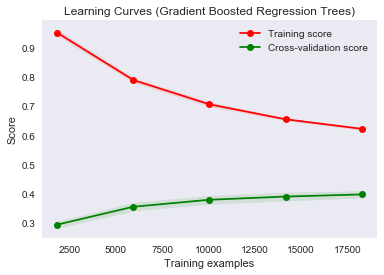

In [58]:
title = "Learning Curves (Gradient Boosted Regression Trees)" 
estimator = GradientBoostingRegressor(n_estimators=best_est.n_estimators, max_depth=best_est.max_depth,
                                      learning_rate=best_est.learning_rate, min_samples_leaf=best_est.min_samples_leaf,
                                      max_features=best_est.max_features)
plot_learning_curve(estimator, title, train_x, train_y, cv=cv, n_jobs=n_jobs)
plt.show()

KeyboardInterrupt: 

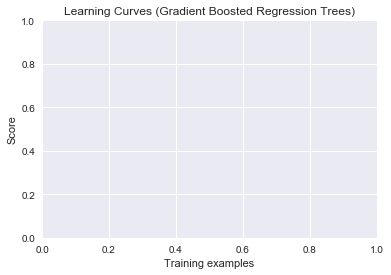

In [20]:
title = "Learning Curves (Gradient Boosted Regression Trees)" 
estimator = GradientBoostingRegressor(n_estimators=500, max_depth=best_est.max_depth,
                                      learning_rate=best_est.learning_rate, min_samples_leaf=best_est.min_samples_leaf,
                                      max_features=best_est.max_features)
plot_learning_curve(estimator, title, train_x, train_y, cv=cv, n_jobs=n_jobs)
plt.show()

/Users/whalejasmine/anaconda/envs/python2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/whalejasmine/anaconda/envs/python2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


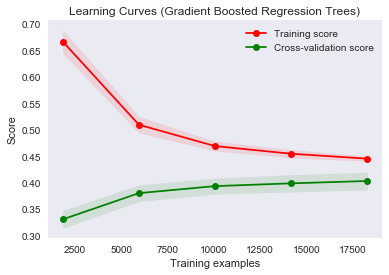

In [19]:
title = "Learning Curves (Gradient Boosted Regression Trees)" 

#Dropping all parameters except n_estimators and learning_rate since we're going to trim the features anyway.
estimator = GradientBoostingRegressor(n_estimators=best_est.n_estimators, learning_rate=best_est.learning_rate)

#Calling fit on the estimator so we can transform the X matrices.
estimator.fit(train_x, train_y)

#Trimming feature matrices to include only those features that are more important than the mean of all importances.
X_train_trim=estimator.transform(train_x, threshold='mean')

#Trimming test as well in case we end up going with this model as final.
X_test_trim=estimator.transform(test_x, threshold='mean')

#Re-plotting Learning cruves.
plot_learning_curve(estimator, title, train_x, train_y, cv=cv, n_jobs=n_jobs)
plt.show()
# not useful/ features are important

In [18]:
estimator = GradientBoostingRegressor(n_estimators=best_est.n_estimators, max_depth=best_est.max_depth,
                                      learning_rate=best_est.learning_rate, min_samples_leaf=best_est.min_samples_leaf,
                                      max_features=best_est.max_features)
estimator.fit(train_x, train_y)

print "Final Estimator Parameters"
print"---------------------------"
print "n_estimators: %d" %best_est.n_estimators
print "max_depth: %d" %best_est.max_depth
print "Learning Rate: %.1f" %best_est.learning_rate
print "min_samples_leaf: %d" %best_est.min_samples_leaf
print "max_features: %.1f" %best_est.max_features
print
print "Final Train R-squared: %.2f" %estimator.score(train_x, train_y)
print "Final Test R-squared: %.2f" %estimator.score(test_x, test_y)

Final Estimator Parameters
---------------------------
n_estimators: 100
max_depth: 6
Learning Rate: 0.1
min_samples_leaf: 3
max_features: 1.0

Final Train R-squared: 0.59
Final Test R-squared: 0.41


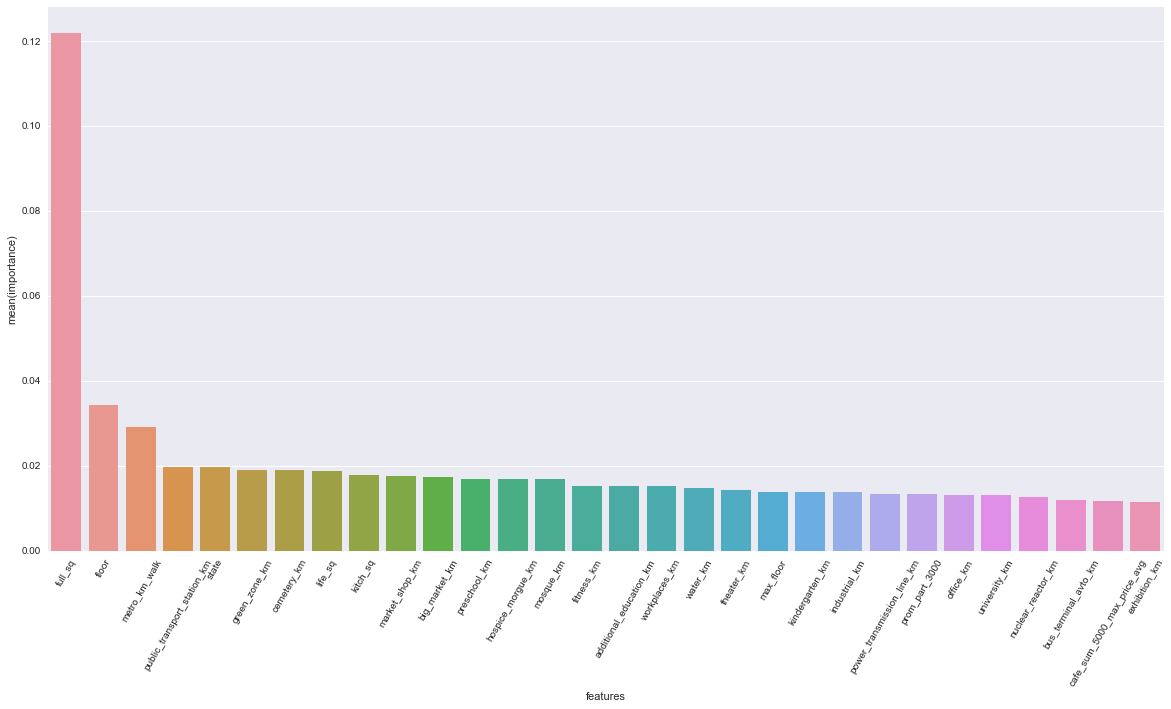

In [19]:
features = pd.DataFrame()
features['features'] = x_train.columns
features['importance'] = best_est.feature_importances_
features.sort_values(by=['importance'],ascending=False,inplace=True)
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
plt.xticks(rotation=60)
sns.barplot(data=features.head(30),x="features",y="importance",ax=ax,orient="v")

### Submission

In [20]:
y_predict = best_est.predict(x_test)
p_y =np.exp(y_predict)-1
id_test = df_test.id
output = pd.DataFrame({'id': id_test, 'price_doc': p_y})
output.head()

,id,price_doc
0,30474,5.414812e+06
1,30475,7.965820e+06
2,30476,5.060377e+06
3,30477,5.448580e+06
4,30478,5.137970e+06


In [21]:
output.to_csv('./data/output/gradboot_tuning.csv', index=False)

In [ ]:
#VIF method to solve multicolinearty 
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=5.0):
    variables = range(X.shape[1])
    dropped=True
    while dropped:
        dropped=False
        vif = [variance_inflation_factor(X[variables].values, ix) for ix in range(X[variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X[variables].columns[maxloc] + '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped=True

    print('Remaining variables:')
    print(X.columns[variables])
    return X[variables]

In [ ]:
train_n_corr.shape

### Comparison of different feature selection